# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

**Hint:** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [2]:
# TODO: Total number of records
n_records = float(data.shape[0])

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = float(data[data.income == '>50K'].shape[0])

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = float(data[data.income == '<=50K'].shape[0])

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = n_greater_50k / n_records * 100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent))

Total number of records: 45222.0
Individuals making more than $50,000: 11208.0
Individuals making at most $50,000: 34014.0
Percentage of individuals making more than $50,000: 24.78%


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

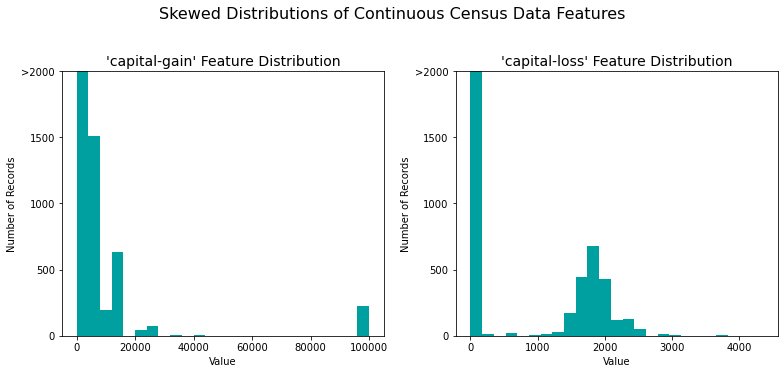

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

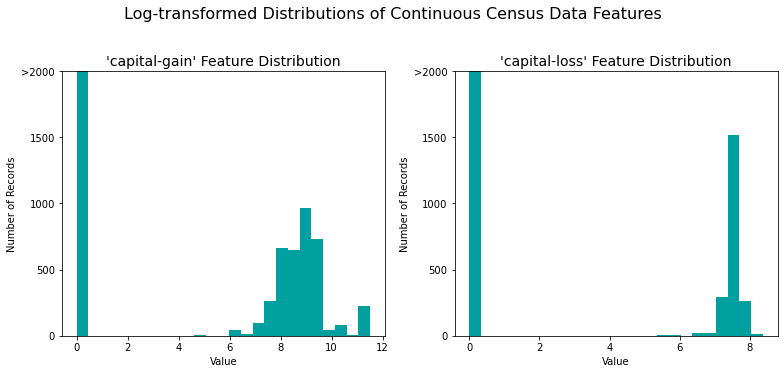

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [6]:
# TODO: One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features_raw)

# TODO: Encode the 'income_raw' data to numerical values
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
income = label_encoder.fit(income_raw).transform(income_raw)

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
print(encoded)

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [7]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *UdacityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would is appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *UdacityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *UdacityML* would identify no one as donors. 

### Question 1 - Naive Predictor Performace
*If we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset?*  
**Note:** You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

###  Supverised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

In [8]:
# TODO: Calculate accuracy
accuracy = n_greater_50k / n_records

# TODO: Calculate F-score using the formula above for beta = 0.5
precision = n_greater_50k / (n_greater_50k + n_at_most_50k)
recall = 1 #False Negative is zero
fscore = (1+0.5**2)*((precision*recall)/((0.5**2)*precision + recall))

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what you know about the data?*

**Answer:**

##### GaussianNB 

A real world application of Naive Bayes is Intrusion Detections Systems with Real-time data. After capturing the network packet data we can analize a lot of its features, like protocol headers, origin, IP addreses, as well as payload contents to check if the patterns of that data match an attack type or any other suspicious or unauthorized activity on a network. We can use GaussianNB if the data distribution matches the gaussian distribution. The model uses the KDD99 dataset which classifies the attacks in 4 types: Denial of Service (DoS), User to Root (U2R), Remote to User (R2L) and Probing. In this research Gaussian distribution is assumed, however, there are some values at the dataset that are not normally distributed so a generalization of this method is used called kernel density estimation for the Gaussian distribution which is a non-parametric density estimates for classification

- Ben Amor, N., Benferhat, S., & Elouedi, Z. (n.d.). Naive Bayesian Networks in Intrusion Detection Systems. Retrieved June 15, 2017, from http://www.sc.ehu.es/ccwbayes/docencia/mmcc/docs/lecturas-clasificacion/abstracts-resumir/BenAmor-IntrusionDetection-2003.pdf


__*--Strengths of the model--*__

- If the data that we want to classify is categorical, it's easy to classify because we can have a predefined label associated to a distribution of probability of its features, so the feature with more probabilities determines the label.

- Features/attributes are assumed to be conditionally independent. This makes the model to perform well.

- Connects inference with classification.

- Estimate parameters with labeled data.

- You can do probabilistic inference over missing attributes since everything is linked by probabilities.


__*--Weaknesses of the model--*__

- It's hard to do exact inference.
- If you have no ocurrences of a class label and a certain feature value together, then the frequency-based probability will be zero. So since Naive Bayes assumes conditional independences, when you multiply all probabilites, the posterior probability will be zero as well.
- Not good for small datasets, because you won't be able to make reliable probability estimations for each class. With a big data set you'll be able to do more reliable probability estimations for each class, so precision and recall will be high. This is because each condition is not truly conditionally independent. An alternative to this is using Linear and Quadratic Discriminant Analysis which is similar to Naive Bayes, but here conditional independence is not assumed. Instead, they use the conditional correlation between features by estimating the co-variance matrix. 

__*--What makes this model a good candidate for the problem--*__

Based on what I know from the data (and the problem too) this seems to be a binary classification problem, where we have 2 possible labels to classify: People who makes more than 50K (>50K) or people who makes at most 50K (<=50K). Is either one or another. Another thing is that the data (after standarizing and preprocessing) has a behavior that responds to a Gaussian distribution.


##### Decision Trees.

A real-world application is student selection when entering to certain universities. For example in the Islamic University of Indonesia when somebody applies to it certain criteria is considerated in order to be a prospective student. These criteria are: Gender, origin, high-school status, concentration/majoring, parents occupation, average value in high school, achievement, type of SSA (Search Student with Achievement).


- Sudiya, A., & H. (2016). Application Of Decision Tree Approach To Student Selection Model– A Case Study. IOP Conf. Series: Materials Science and Engineering, 2-9. doi:10.1088/1757-899X/105/1/012014


__*--Strengths of the model--*__

- If we find an attribute/feature that splits the data, it will perform well. This is because this model prefers trees that have good splits at the top node.
- It's preferred shorter trees to longer trees. This naturally comes with having good splits at the top. By having shorter trees we prevent overfitting.
- It's great for working with discrete features, because you can't repeat a feature along a path in a tree.
- Correct over incorrect. Assuming ID3 algorithm: Given a tree that has very good splits at the top but produces the wrong answer, it would not take that one over one that doesn't have  as good splits at the top but does give you the correct answer.

__*--Weaknesses of the model--*__

- It performs bad with noisy data. If we have 2 examples of the same object, same instance, but with different labels, the algorithm (assuming ID3 algorithm) can enter in an infinite loop.
- It performs bad if we choose an attribute that doesn't split the data. This could introduce bias.
- It performs bad if make longer trees, because this tends to overfit.
- If we want to work with continous features, it could be problematic because for each value we would have to make a new node for it, increasing the complexity of the tree. For example let's say that in a node we want to ask about the age, if the age is greater than 25, the values we have are: 25.0, 25.1, 26.3, 27.8. We would have to create one node per age. So if the age is actually greater than 25 we can't choose the node with 25.0, but we have to choose the other nodes greater than 25 (25.1, 26.3 or 27.8) so which one do we choose? To sort this out what we have to do is to ask in the node whether the age is on a certain range, like 25 <= age <= 28.


__*--What makes this model a good candidate for the problem--*__

The goal of the project is to predict if a person makes more than 50K or at most 50K, so we have only 2 possible labels: >50K or <=50K. One of the main things of this model is that we must stop not only when it classified correctly, but also when there's no more features to evaluate. And the data we have here doesn't have too many features. Following on that idea, if we then select a subset of those features to consider whether a person is classified as >50K or <=50K this means that we need to evaluate less features, so the model will perform better and overfitting may decrease. This is why I cosider Decision Tree as a good candidate model for this project.


##### Support Vector Machines (SVM).

A real world application of SVM is the detection or certain diseases like diabetes or pre-diabetes earlier so the appropiate treatment can be provided to the patient. In a study (which reference is cited on this notebook) 14 features were used in the dataset to achieve this: family history, family history, age, gender, race and ethnicity, weight, height, waist circumference, BMI, hypertension, physical activity, smoking, alcohol use, education, and household income. With this they generated an hyperplane that optimally discriminate between the 2 classes: Classification scheme 1 (People with diagnosed or undiagnosed diabetes) and classification scheme 2 (People with pre-diabetes or no diabetes).


- Yu, W., Liu, T., Valdez, R., Gwinn, M., & Khoury, M. J. (2010). Application of support vector machine modeling for prediction of common diseases: the case of diabetes and pre-diabetes. BMC Medical Informatics and Decision Making. doi:10.1186/1472-6947-10-16


__*--Strengths of the model--*__

- If classes cannot be separated using a line on a 2D space it can use a plane projected in the 3D space to optimally separate the data classes.

- We can use a variety of kernel functions that suits our needs. The way to know if it suits our needs is to check if the Kernel functions shares a notion of similarity with our data.

- We can also play with the alpha and C parameters as well. With these along with the kernel functions we can see if our model is prone to overfitting.


__*--Weaknesses of the model--*__

- SVMs don't work well with lots and lots of noise, so when the classes are very overlapping, you have to count independent evidence.

- The problem to be solved with SVM has to be formulated as a 2-class classification problem.


__*--What makes this model a good candidate for the problem--*__

This is a 2-class classification problem, since we need a model that tells us whether a person earns '>50K' or '<=50K' yearly and SVM is a good model that suits to this problem. Also since some of the features have a Gaussian distribution we can use the RBF kernel which is based on a gaussian function and can optimally help us in the classification process.





In [9]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,beta=0.5)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test,predictions_test,beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Dependent on which algorithms you chose, the following implementation may take some time to run!

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

GaussianNB trained on 362 samples.
GaussianNB trained on 3618 samples.
GaussianNB trained on 36177 samples.
DecisionTreeClassifier trained on 362 samples.
DecisionTreeClassifier trained on 3618 samples.
DecisionTreeClassifier trained on 36177 samples.
SVC trained on 362 samples.
SVC trained on 3618 samples.
SVC trained on 36177 samples.


/Users/juanjpolanco/Documents/ML projects portfolio/Project2/visuals.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  pl.tight_layout()


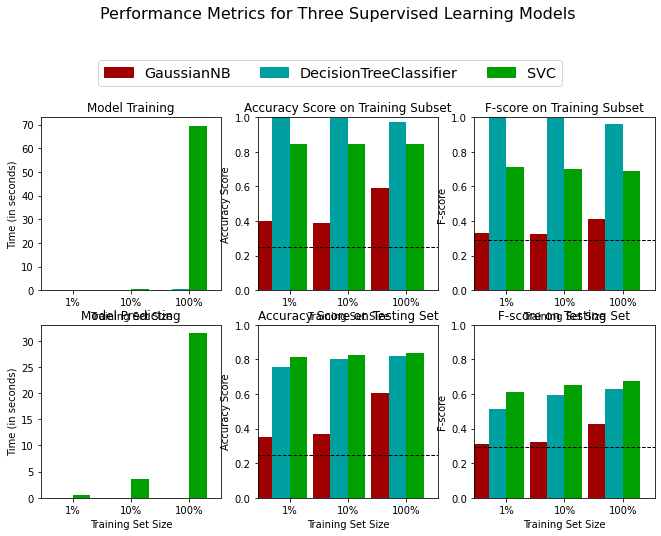

In [11]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# TODO: Initialize the three models
clf_A = GaussianNB()
clf_B = DecisionTreeClassifier(random_state=42)
clf_C = SVC(kernel='rbf', C=1,random_state=42)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(round(X_train.shape[0] * 0.01))
samples_10 = int(round(X_train.shape[0] * 0.1))
samples_100 = int(round(X_train.shape[0]))

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

### Question 3 - Choosing the Best Model
*Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000.*  
**Hint:** Your answer should include discussion of the metrics, prediction/training time, and the algorithm's suitability for the data.

**Answer:** The model I believe is the appropiate to identify individuals that make more than 50,000 is the DecisionTreeClassifier because compared to the other 2 models it has the lowest time in training and predicting, and also has better accuracy scores and f-scores on testing as the testing set sample grows. Despite it has slightly low accuracy and f scores on testing set compared to SVC, it remains consistent when predicting on unseen data. A higher F-score on testing set (prediction) tells how well that model generalizes on which individuals make more than 50,000 because the F-score metric is set up with a low beta (0.5) which is focused more on precision than recall. Even though SVC has good and consistent accuracy and F-scores, I don't choose it because of the predicting and training time which increases as the training and testing data grows. The DecisionTreeClassifier is suitable for this data since the data has more categorical features, than numerical, which makes easier the evaluation of the features than a numerical one. For the numerical ones, normalization/scaling was previously applied so those numerical features can be treated equally.

### Question 4 - Describing the Model in Layman's Terms
*In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer:** The DecisionTreeClassifier is trained this way: The DecisionTreeClassifier classifies the data by taking one attribute that is common to all of the individuals that makes more than 50,000. After this the data is splitted into 2 groups: the one that have this attribute in common (group A) and the other group that don't (group B). Then in group A, we select another attribute that this group have in common and we split the data again (the group that has it and the other that don't). We continue this process until we have explored all the features. 

The model makes a prediction this way: It picks an attribute, then he ask a question about it, he follows the answer path until he arrives to the final answer. After that it stops.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [14]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# TODO: Initialize the classifier
clf = DecisionTreeClassifier(random_state=42)

# TODO: Create the parameters list you wish to tune
parameters = {'max_depth':[1,2,3,4,5,6,7,8,9,10], 'min_samples_leaf':[1,2,3]}

# TODO: Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf,parameters,scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train,y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8187
F-score on testing data: 0.6282

Optimized Model
------
Final accuracy score on the testing data: 0.8525
Final F-score on the testing data: 0.7230


### Question 5 - Final Model Evaluation
_What is your optimized model's accuracy and F-score on the testing data? Are these scores better or worse than the unoptimized model? How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  
**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |        0.2478       |      0.8190       |     0.8532      |
| F-score        |        0.2917       |      0.6289       |     0.7243      |


**Answer:** The optimized model is better than the unoptimized model in both accuracy score (3.42% better) and F-score (9.54% better). Comparing the optimized model against the benchmark predictor the accuracy increases in 60.54% and the F-score in 43.26%. It's a huge leap in performance on the testing set since the benchmark predictor has less precision than recall, so it can't verify that the individuals that it says that make >50K really make more than 50K, so the naive predictor is poor on generalizing. So the unoptimized model improves that by choosing an appropiate algorithm that correctly classifies the ones that make >50K. The optimized model uses the same algorithm as the unoptimized one, the difference is that the optimized one benefits from the GridSearchCV parameter tuning to find the best parameters.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?_

**Answer:** 

1. Native Country: Because each country have different economies/currencies where one can be stronger than other, so in some countrys will be easier to make 50,000 USD anually than others. In 3rd-world countries it will be more difficult to make 50,000 USD than in 1st-world countries.

2. Work-class: Work-class can give you an estimate on how much you'll be making anually. It also can give you some estimate on how much tax will you have to pay as well. It's not the same work as a Private worker than a self-employed worker, the amount of taxes that each one has to pay might be different depending on the country. Also if someone has a Never-worked work-class it's a person that has no income, so he doesn't make 50,000 USD.

3. Occupation: The occupation along with the work class determine how much you'll be making anually (as well as the taxes that you'll be paying that will impact on your net income).

4. Capital loss. If somebody has real-state property, a business or any other asset that can lose value over time, he/she is losing capital and this impacts on the anually net income.

5. Capital gain. Contrary to capital-loss if your assets increase value over time this will determine the likelihood of earning certain income.

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

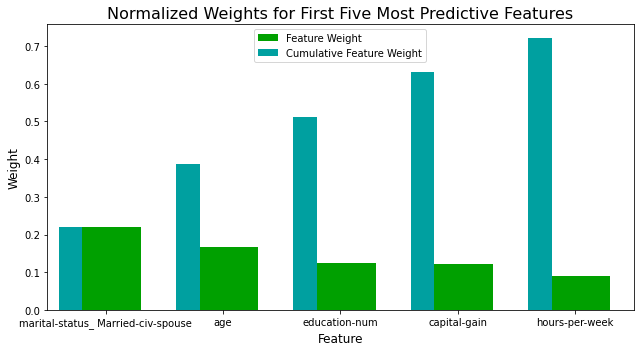

In [15]:
# TODO: Import a supervised learning model that has 'feature_importances_'
model = DecisionTreeClassifier(random_state=42)
# TODO: Train the supervised model on the training set 
model = model.fit(X_train, y_train)

# TODO: Extract the feature importances
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
_How do these five features compare to the five features you discussed in **Question 6**? If you were close to the same answer, how does this visualization confirm your thoughts? If you were not close, why do you think these features are more relevant?_

**Answer:** I wasn't close to the graph. The only one I matched was capital-gain, then the rest of features weren't close to the one I chose. 

1. __*marital-status_Married-civ-spouse.*__ I think this one could be important because a married individual share household expense with his/her spouse. So it means it has to spend less, and this increase his/her net income. This is of course assuming they don't have any children.

2. __*Age.*__ Age could also determine if you make more than 50K USD because younger workers are more likely to enter to specialized and high-paid jobs (depends on education too). Older individuals (specially if they are near the age of retirement, unless they are on a specialized and high-demanded field where their experience is highly valuable) are less likely to make more than 50K USD.

3. __*Education-num.*__ I didn't understood what this feature meant in the dataset, but I guess it's related to the education years. If it's related to the years of education, this means that a person with more years of education is more likely to enter to specialized jobs which are more likely to pay a salary greater than 50K USD.

4. __*Capital-gain.*__ As I mentioned in question 6 capital gain determines the likelihood of making more or at most 50K USD, depending on the value that your assets generate over time.

5. __*Hours per week.*__ A person who is self-employed for example and charges a certain amount per hour, if he works more hours (more than the traditional 40 hours) it's more likely to earn more. Also this applies if that person is a CEO he/she is more likely to work more hours and the salary it's bigger.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [17]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8525
F-score on testing data: 0.7230

Final Model trained on reduced data
------
Accuracy on testing data: 0.8449
F-score on testing data: 0.7053


### Question 8 - Effects of Feature Selection
*How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?*  
*If training time was a factor, would you consider using the reduced data as your training set?*

**Answer:** I see that the final model trained on reduced data had a slight decrease on accuracy and F-score. If training time were a factor I'll consider using the reduced data as the training set, but keeping an eye in the kind of model where I'm going to use it because it can cost you on performance metrics, like in this example. So my final thought is that depending on the problems data and model you choose you can use reduced data or not.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.